# Santa Detection Network

In this notebook we will build a neural network model to recognize santa images using camera and GPU capabilities on Jetson Nano.

This notebooks contains code written by Adrian Rosebrock and located at https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/. 

# 0. Configuration and Preparation

Mount the Google Drive, Unzip the image archive, and import the necessary packages.

In [1]:
## Mount the Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
## Change the working directory for the notebook
%cd '/content/gdrive/My Drive/dscamp/dscamp_public/Advanced Models II/Convolutional Neural Networks'

/content/gdrive/My Drive/dscamp/dscamp_public/Advanced Models II/Convolutional Neural Networks


In [3]:
%ls images

not_santa/  not_santa.zip  santa/  santa_a.zip  santa_b.zip


In [4]:
## RUN THIS ONLY ONCE 
## Unzip the image archive
!unzip -o images/not_santa.zip -d images
!unzip -o images/santa_a.zip -d images/santa
!unzip -o images/santa_b.zip -d images/santa
# (the -o flag is to ovewrite the existing images without asking a second time, so you don't need to answer a question about every image)

Archive:  images/not_santa.zip
  inflating: images/not_santa/00000000.jpg  
  inflating: images/not_santa/00000001.jpg  
  inflating: images/not_santa/00000002.jpg  
  inflating: images/not_santa/00000003.jpg  
  inflating: images/not_santa/00000004.jpg  
  inflating: images/not_santa/00000005.jpg  
  inflating: images/not_santa/00000006.jpg  
  inflating: images/not_santa/00000007.jpg  
  inflating: images/not_santa/00000008.jpg  
  inflating: images/not_santa/00000009.jpg  
  inflating: images/not_santa/00000010.jpg  
  inflating: images/not_santa/00000011.jpg  
  inflating: images/not_santa/00000012.jpg  
  inflating: images/not_santa/00000013.jpg  
  inflating: images/not_santa/00000014.jpg  
  inflating: images/not_santa/00000015.jpg  
  inflating: images/not_santa/00000016.jpg  
  inflating: images/not_santa/00000017.jpg  
  inflating: images/not_santa/00000018.jpg  
  inflating: images/not_santa/00000019.jpg  
  inflating: images/not_santa/00000020.jpg  
  inflating: images/not_

## Network Parameters

In [5]:
## Parameters for the detector
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
CONV_FILT_1 = 20
CONV_FILT_2 = 50
DENSE_N = 500 

In [6]:
import warnings
warnings.simplefilter('ignore')
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dense
from tensorflow.keras import backend as K
import matplotlib


from tensorflow. keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from imutils import paths
import imutils
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
from PIL import Image
import requests
from io import BytesIO

from google.colab.patches import cv2_imshow

In [7]:
# LeNet is the network proposed by Yann LeCun et al for variety of letter recognition tasks
# for more details see the original paper: http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)
        
        if K.image_data_format() == "channels_first":
            inputShape = (depth, heaight, width)
        model.add(Conv2D(CONV_FILT_1, (5, 5), padding="same",
                         input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Conv2D(CONV_FILT_2, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Flatten())
        model.add(Dense(DENSE_N))
        model.add(Activation("relu"))
        
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        return model

In [8]:
path_dataset = "images"
path_model = "santa_detector.model"
path_plot = "accuracy_plot.png"

In [9]:
print("[INFO] loading images...")
data = []
labels = []

imagePaths = sorted(list(paths.list_images(path_dataset)))
random.seed(42)
random.shuffle(imagePaths)

[INFO] loading images...


In [10]:
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (28, 28))
    image = img_to_array(image)
    data.append(image)
    
    label = imagePath.split(os.path.sep)[-2]
    label = 1 if label == "santa" else 0
    labels.append(label)

In [11]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data,
                                    labels, test_size=0.25, random_state=42)

trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                        height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                        horizontal_flip=True, fill_mode="nearest")

In [12]:
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=3, classes=2)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
             metrics=["accuracy"])

print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
                       validation_data=(testX, testY), steps_per_epoch=len(trainX)// BS,
                       epochs=EPOCHS, verbose=1)

print("[INFO] serizalizing network...")
model.save(path_model)

[INFO] compiling model...
[INFO] training network...
Epoch 1/50
21/21 [==============================] - 3s 108ms/step - loss: 0.6708 - accuracy: 0.5630 - val_loss: 0.5824 - val_accuracy: 0.4978
Epoch 2/50
21/21 [==============================] - 2s 96ms/step - loss: 0.5447 - accuracy: 0.6950 - val_loss: 0.3447 - val_accuracy: 0.9048
Epoch 3/50
21/21 [==============================] - 2s 97ms/step - loss: 0.4084 - accuracy: 0.8240 - val_loss: 0.1982 - val_accuracy: 0.9437
Epoch 4/50
21/21 [==============================] - 2s 99ms/step - loss: 0.3135 - accuracy: 0.8665 - val_loss: 0.3455 - val_accuracy: 0.8701
Epoch 5/50
21/21 [==============================] - 2s 100ms/step - loss: 0.2387 - accuracy: 0.8983 - val_loss: 0.1158 - val_accuracy: 0.9784
Epoch 6/50
21/21 [==============================] - 2s 98ms/step - loss: 0.2405 - accuracy: 0.9029 - val_loss: 0.1322 - val_accuracy: 0.9610
Epoch 7/50
21/21 [==============================] - 2s 97ms/step - loss: 0.2139 - accuracy: 0.9135 

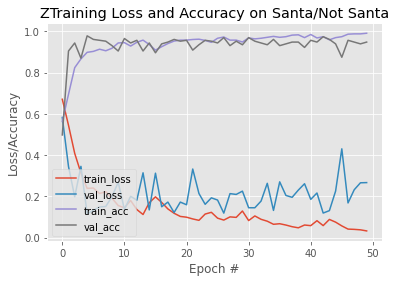

In [13]:
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("ZTraining Loss and Accuracy on Santa/Not Santa")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(path_plot)
plt.show()

![title](accuracy_plot.png)

# Make a prediction

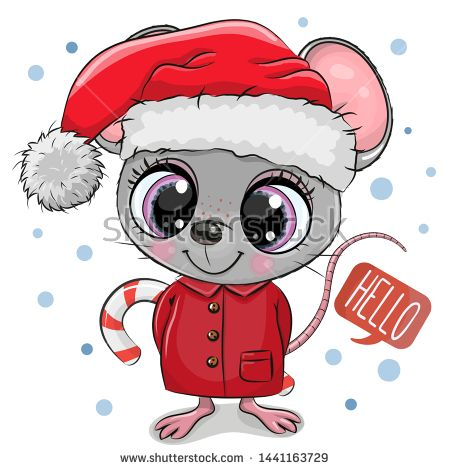

In [14]:
req = requests.get("https://i.pinimg.com/474x/f8/9b/1a/f89b1ac380c1dba6d9763f26c0fd8083.jpg")
arr = np.asarray(bytearray(req.content), dtype=np.uint8)
img = cv2.imdecode(arr, -1)
cv2_imshow(img)
if cv2.waitKey() & 0xff == 27: quit()

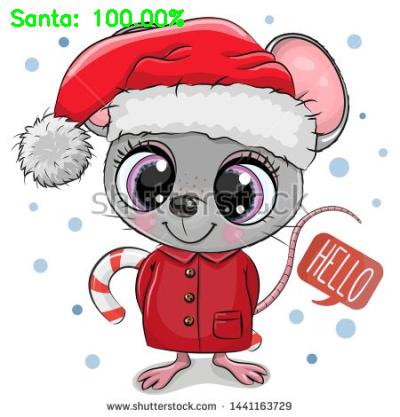

In [15]:
img = imutils.resize(img, width=400)
image = cv2.resize(img, (28, 28))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
(notSanta, santa) = model.predict(image)[0]
label = "Not Santa"
proba = notSanta
if santa > notSanta:
    label = "Santa"
    proba = santa
label = "{}: {:.2f}%".format(label, proba * 100)
img = cv2.putText(img, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

cv2_imshow(img)
if cv2.waitKey() & 0xff == 27: quit()